In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import figures as f

#import os
#os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
#os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

import retrieval_base.auxiliary_functions as af
import pymultinest
import json
import copy

from tqdm import tqdm

import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

In [2]:
def read_results(prefix, n_params, m_set='K2166_cloudy', w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()
    ln_Z = stats['nested importance sampling global log-evidence']

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return ln_Z, posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

#prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_4/test_'
#prefix_no_band = './retrieval_outputs/no_bands_K_A_ret_1/test_'
prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_5/test_'
res = read_results(prefix=prefix_no_band, n_params=26)
ln_Z_no_band, _, _, _, _, _, _, _, m_spec_no_band, d_spec, LogLike_no_band, Cov_no_band, bestfit_params_no_band = res
del res

#prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_1/test_'
#prefix_eq_band = './retrieval_outputs/eq_band_K_A_ret_2/test_'
prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_2/test_'
res = read_results(prefix=prefix_eq_band, n_params=28)
ln_Z_eq_band, _, _, _, _, _, _, _, m_spec_eq_band, d_spec, LogLike_eq_band, Cov_eq_band, bestfit_params_eq_band = res
del res

  analysing data from ./retrieval_outputs/no_bands_K_B_ret_5/test_.txt
  analysing data from ./retrieval_outputs/eq_band_K_B_ret_2/test_.txt


In [3]:
def get_Rot(prefix, m_set='K2166_cloudy'):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{m_set}.pkl')
    Rot = copy.copy(pRT_atm.Rot)

    return Rot

Rot_no_band = get_Rot(prefix_no_band)
Rot_eq_band = get_Rot(prefix_eq_band)

k_B = 1.3807e-16    # cm^2 g s^-2 K^-1
c   = 2.99792458e10 # cm s^-1
amu = 1.66054e-24   # g

mass = (2*1+16)*amu # H2O
T = 1200
P = 1

# Central wavelength/wavenumber
p_wave_cen = np.nanmean(d_spec.wave[2])
p_wn_cen   = 1e7/p_wave_cen

p_wave = p_wave_cen + np.linspace(-1,1,1000)
p_wn   = 1e7/p_wave

# Broadening parameters
gamma_G = np.sqrt((2*k_B*T)/mass) * p_wn_cen/c
gamma_L = 0.06

# Use a Voigt profile
from scipy.special import wofz as Faddeeva

u = (p_wn - p_wn_cen) / gamma_G
a = gamma_L / gamma_G
p_flux = Faddeeva(u + 1j*a).real
p_flux = 1 - p_flux/np.max(p_flux)

# Broaden the line profile
_, p_flux_no_band = Rot_no_band(
    wave=p_wave, 
    flux=p_flux, 
    params=bestfit_params_no_band['params']['K2166_cloudy'], 
)

#f_grid = Rot_no_band.get_f_grid(bestfit_params_no_band['params']['K2166_cloudy'])
#integrated_f_grid = np.sum(f_grid*Rot_no_band.area_per_segment)

_, p_flux_eq_band = Rot_eq_band(
    wave=p_wave, 
    flux=p_flux, 
    params=bestfit_params_eq_band['params']['K2166_cloudy'], 
)
p_flux_eq_band /= np.pi

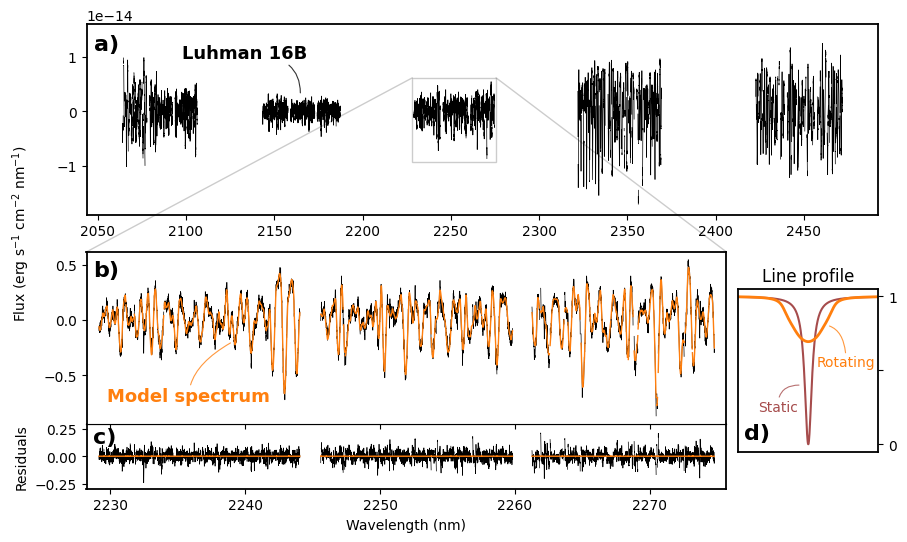

In [80]:
sep_1 = 0.08
sep_2 = 0.08
#offset_2 = 0.02

fig = plt.figure(figsize=(9,6*0.9))
gs = fig.add_gridspec(
    #nrows=4, ncols=1, hspace=0, wspace=0.02, height_ratios=[0.42,0.06,0.42,0.1]
    nrows=6, ncols=2, hspace=0, wspace=0.03, 
    height_ratios=[0.41, sep_1, sep_2,0.37-sep_2, 0.14-sep_2,sep_2], 
    width_ratios=[0.82,0.18]
    )
ax = np.array([
    fig.add_subplot(gs[0,:]), 
    fig.add_subplot(gs[2:4,0]), 
    fig.add_subplot(gs[-2:,0]), 

    fig.add_subplot(gs[3:5,1]), 
    ])

scale = 1e14

for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        ax[0].plot(d_spec.wave[i,j], d_spec.flux[i,j], c='k', lw=0.5)
        #ax[0].plot(d_spec.wave[i,j], LogLike_eq_band.m_flux_phi[i,j], c='C1', lw=1.5)

        if i == 2:
            ax[1].plot(d_spec.wave[i,j], scale*(d_spec.flux[i,j]), c='k', lw=0.5)
            ax[1].plot(d_spec.wave[i,j], scale*(LogLike_eq_band.m_flux_phi[i,j]), c='C1', lw=1)

            ax[2].plot(d_spec.wave[i,j], scale*(d_spec.flux[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='k', lw=0.5)
            ax[2].plot(d_spec.wave[i,j], scale*(LogLike_eq_band.m_flux_phi[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='C1', lw=1)

            #ax[1].plot(d_spec.wave[i,j], scale*(LogLike_no_band.m_flux_phi[i,j]), c='C2', lw=1)
            #ax[2].plot(d_spec.wave[i,j], scale*(LogLike_no_band.m_flux_phi[i,j]-LogLike_eq_band.m_flux_phi[i,j]), c='C2', lw=1)

            ax[1].set(xlim=(d_spec.wave[i,:].min()-0.7, d_spec.wave[i,:].max()+0.7))
            ax[2].set(xlim=ax[1].get_xlim())

#ax[0].set(ylabel='High-pass filtered flux '+r'$\mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$')
#ax[1].set(ylim=ax[0].get_ylim)
ax[0].set(ylim=(-1.9e-14,1.6e-14))
ax[1].set(xticklabels=[])
ax[2].set(xlabel=r'Wavelength (nm)', ylabel='Residuals')

x0 = ax[1].get_xlim()[0]
y0 = ax[1].get_ylim()[0]/scale
width  = np.abs(ax[1].get_xlim()[1] - x0)
height = np.abs(ax[1].get_ylim()[1]/scale - y0)
bounds = (x0, y0, width, height)

_, con_patch = ax[0].indicate_inset(
    bounds=bounds, inset_ax=ax[1], edgecolor='k', alpha=0.2, 
    )

height_ratio = ax[2].get_position().bounds[-1] / ax[1].get_position().bounds[-1]
#height_ratio = gs.get_height_ratios()[3] / gs.get_height_ratios()[2]
ax[2].set_ylim(-0.5*height_ratio*height*scale, +0.5*height_ratio*height*scale)
#print(np.diff(ax[2].get_ylim())/np.diff(ax[1].get_ylim()), 0.1/0.42)

spine_lw = 1.3
ax[0].spines[['left','right','top','bottom']].set_linewidth(spine_lw)
ax[1].spines[['left','right','top']].set_linewidth(spine_lw)
ax[2].spines[['left','right','bottom']].set_linewidth(spine_lw)
ax[2].set_zorder(-2)

plt.subplots_adjust(left=0.09, bottom=0.09, top=0.95, right=0.97)

l0, b0, w0, h0 = ax[0].get_position().bounds
l1, b1, w1, h1 = ax[1].get_position().bounds

x0 = l0 - 0.061
y0 = np.mean([b1+h1, b0])

fig.text(
    x0, y0, 'Flux '+r'$\mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    rotation=90, ha='right', va='center', 
    )

ax[-1].plot(p_wave-p_wave_cen, p_flux, c='maroon', lw=1.5, alpha=0.7)
ax[-1].annotate(
    'Static', xy=(-0.07,0.4), xytext=(-0.23,0.3), ha='center', va='top', c='maroon', alpha=0.7,
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=0', 
        'shrinkA':0, 'shrinkB':0, #'arrowstyle':']-',
        'lw':0.8, 'color':'maroon', 'alpha':0.7*0.8, 
        }, 
    )

ax[-1].plot(p_wave-p_wave_cen, p_flux_eq_band, c='C1', lw=2, alpha=1)
ax[-1].annotate(
    'Rotating', xy=(0.16,0.8), xytext=(0.285,0.6), ha='center', va='top', c='C1', 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=-20', 
        'shrinkA':0, 'shrinkB':0, #'arrowstyle':']-',
        'lw':0.8, 'color':'C1', 'alpha':0.8, 
        }, 
    )

#ax[-1].annotate('Rotation', xy=(0.08,0.65))
ax[-1].set(
    title='Line profile', xlim=(-0.53,0.53), xticks=[], 
    yticks=[0.,0.5,1.], yticklabels=['0','','1']
    )
ax[-1].spines[['left','right','top','bottom']].set_linewidth(spine_lw)
ax[-1].tick_params(left=False, labelleft=False, right=True, labelright=True)

font_kwargs = dict(fontsize=16, fontweight='bold')
ax[0].annotate('a)', xy=(0.01,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[1].annotate('b)', xy=(0.01,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[2].annotate('c)', xy=(0.01,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[3].annotate('d)', xy=(0.04,0.05), xycoords='axes fraction', ha='left', va='bottom', **font_kwargs)

ax[0].annotate(
    'Luhman 16B', xy=(0.27,0.64), xytext=(0.2,0.8), xycoords='axes fraction', 
    ha='center', va='bottom', c='k', fontsize=13, fontweight='bold', 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=90', 
        'shrinkA':0, 'shrinkB':0, 'lw':0.8, 'color':'k', 'alpha':0.8, 
        }, 
    )
ax[1].annotate(
    'Model spectrum', xy=(0.225,0.47), xytext=(0.16,0.21), xycoords='axes fraction', 
    ha='center', va='top', c='C1', fontsize=13, fontweight='bold', 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=30', 
        'shrinkA':0, 'shrinkB':0, 'lw':0.8, 'color':'C1', 'alpha':0.8, 
        }, 
    )

plt.savefig('./plots/banded_cloud_spec_B.pdf')
plt.show()